In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from scipy.optimize import curve_fit

# Set gnuplot style
plt.style.use('classic')

# Lab ley de Malus y fotoelasticidad

In [33]:
df = pd.read_csv("p1.csv", header=None)
print(df.head())

theta_deg = df.iloc[:, 0].values
intensidad = df.iloc[:, 1].values
theta_rad = np.deg2rad(theta_deg)

    0       1
0   0  1201.1
1  10  1175.0
2  20  1072.0
3  30   918.7
4  40   694.5


In [34]:
# Modelo con ángulo de polarización
def ley_malus(theta, I0, theta0):
    return I0 * np.cos(theta - theta0)**2

# Ajuste
popt, pcov = curve_fit(ley_malus, theta_rad, intensidad, p0=[max(intensidad), 0])
I0, theta0 = popt
I0_err, theta0_err = np.sqrt(np.diag(pcov))

# Convertir theta0 a grados
theta0_deg = np.rad2deg(theta0)
theta0_err_deg = np.rad2deg(theta0_err)

# Calcular R²
residuos = intensidad - ley_malus(theta_rad, *popt)
ss_res = np.sum(residuos**2)
ss_tot = np.sum((intensidad - np.mean(intensidad))**2)
r_squared = 1 - (ss_res / ss_tot)

In [35]:
# Imprimir resultados
print(f"I0 = {I0:.4f} ± {I0_err:.4f}")
print(f"Ángulo de polarización (θ₀) = {theta0_deg:.2f} ± {theta0_err_deg:.2f} grados")
print(f"R² = {r_squared:.4f}")



I0 = 1144.7727 ± 7.0388
Ángulo de polarización (θ₀) = 0.60 ± 0.31 grados
R² = 0.9962


In [36]:
# Preparar datos para la curva ajustada
theta_fit_deg = np.linspace(min(theta_deg), max(theta_deg), 300)
theta_fit_rad = np.deg2rad(theta_fit_deg)
intensidad_fit = ley_malus(theta_fit_rad, *popt)

# Texto para la gráfica
texto_ajuste = (
    r"$I(\theta) = I_0 \cos^2(\theta - \theta_0)$" + "\n"
    + fr"$I_0 = {I0:.2f} \pm {I0_err:.2f}$" + "\n"
    + fr"$\theta_0 = {theta0_deg:.2f} \pm {theta0_err_deg:.2f}^\circ$" + "\n"
    + fr"$R^2 = {r_squared:.4f}$"
)

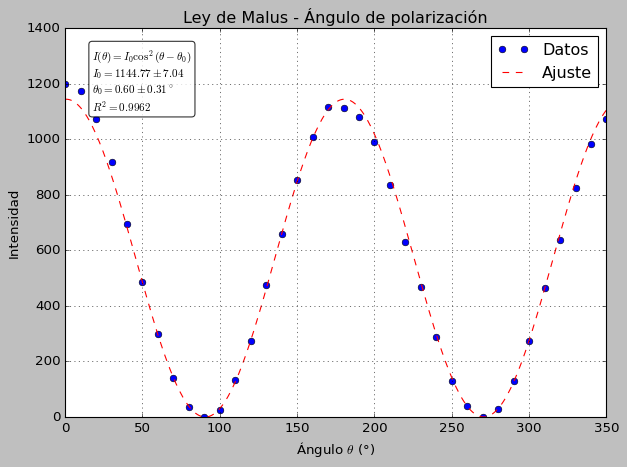

<Figure size 640x480 with 0 Axes>

In [ ]:
# Graficar
plt.plot(theta_deg, intensidad, 'o', label='Datos')
plt.plot(theta_fit_deg, intensidad_fit, 'r--', label='Ajuste')
plt.xlabel(r'Ángulo $\theta$ (°)')
plt.ylabel('Intensidad')
plt.title('Ley de Malus - Ángulo de polarización')
plt.legend()
plt.grid(True)
plt.text(0.05, 0.95, texto_ajuste, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig("Malus_p1_cartesiana.png")
plt.show()

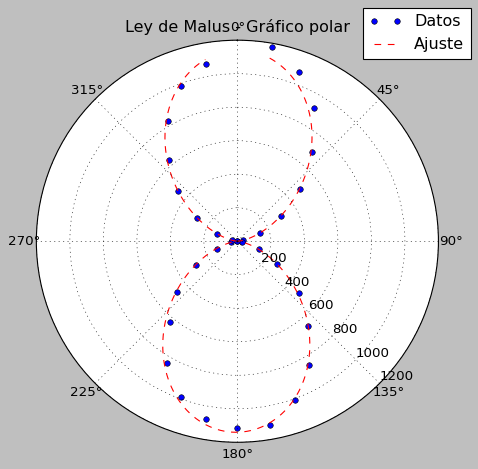

In [12]:
# Crear figura polar
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)

# Datos experimentales (convertir ángulo a radianes)
ax.plot(theta_rad, intensidad, 'o', label='Datos', markersize=5)

# Curva ajustada
ax.plot(theta_fit_rad, intensidad_fit, 'r--', label='Ajuste')

# Estética del gráfico
ax.set_title('Ley de Malus - Gráfico polar', va='bottom')
ax.set_theta_zero_location('N')  # 0° hacia arriba
ax.set_theta_direction(-1)       # Sentido horario
ax.set_rlabel_position(135)      # Posición de etiquetas de radio
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.tight_layout()
plt.savefig("Malus_p1_polar.pdf")
plt.show()


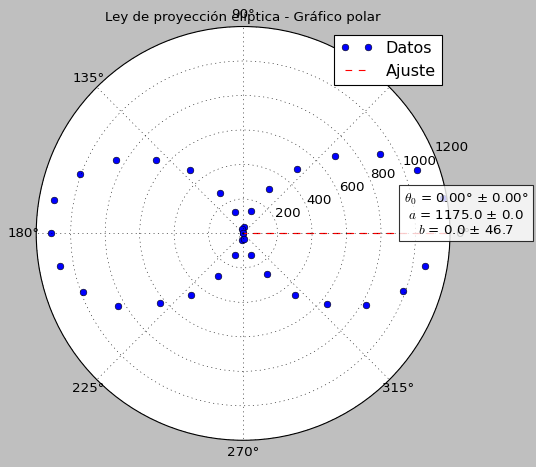

In [16]:
# --------------------------
# Definir modelo elíptico
# --------------------------
def eliptico(theta, a, b, theta0):
    num = a * b
    denom = np.sqrt((b * np.cos(theta - theta0))**2 + (a * np.sin(theta - theta0))**2)
    return num / denom

# Estimar parámetros iniciales
p0 = [np.max(intensidad), np.min(intensidad), 0]

# Ajustar con límites razonables
bounds = ([0, 0, -np.pi], [np.inf, np.inf, np.pi])
popt, pcov = curve_fit(eliptico, theta_rad, intensidad, p0=p0, bounds=bounds)
a_fit, b_fit, theta0_fit = popt
da, db, dtheta0 = np.sqrt(np.diag(pcov))

# Preparar curva ajustada
theta_fit = np.linspace(0, 2*np.pi, 500)
ajuste_fit = eliptico(theta_fit, *popt)

# --------------------------
# Graficar en coordenadas polares
# --------------------------
plt.subplot(111, polar=True)
plt.plot(theta_rad, intensidad, 'bo', label='Datos')
plt.plot(theta_fit, ajuste_fit, 'r--', label='Ajuste')

plt.title('Ley de proyección elíptica - Gráfico polar', fontsize=12)
plt.legend(loc='upper right')

# Mostrar parámetros ajustados
plt.text(0, a_fit*1.1,
         f'$\\theta_0$ = {np.degrees(theta0_fit)%180:.2f}° ± {np.degrees(dtheta0):.2f}°\n'
         f'$a$ = {a_fit:.1f} ± {da:.1f}\n'
         f'$b$ = {b_fit:.1f} ± {db:.1f}',
         bbox=dict(facecolor='white', alpha=0.8), ha='center')

plt.tight_layout()
plt.show()

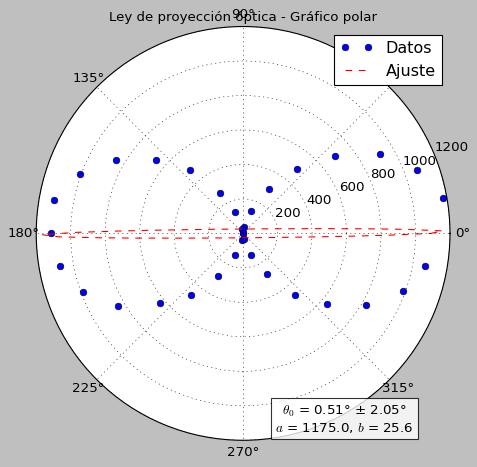

In [26]:
# Eliminar valores con intensidad muy baja (cercanos a cero), típicamente < 5% del máximo
umbral = 0.001 * np.max(intensidad)
mask = intensidad > umbral
theta_filtrado = theta_rad[mask]
intensidad_filtrada = intensidad[mask]

# Redefinir a y b con datos filtrados
a_data = np.max(intensidad_filtrada)
b_data = np.min(intensidad_filtrada)

# Modelo con a y b fijos, solo ajustamos theta0
def modelo_eliptico(theta, theta0):
    num = a_data * b_data
    denom = np.sqrt((b_data * np.cos(theta - theta0))**2 + (a_data * np.sin(theta - theta0))**2)
    return num / denom

# Ajustar el ángulo theta0
popt, pcov = curve_fit(modelo_eliptico, theta_filtrado, intensidad_filtrada, p0=[0])
theta0_fit = popt[0]
dtheta0 = np.sqrt(np.diag(pcov))[0]

# Curva ajustada para graficar
theta_fit = np.linspace(0, 2*np.pi, 500)
ajuste_fit = modelo_eliptico(theta_fit, theta0_fit)

# Graficar en coordenadas polares
ax = plt.subplot(111, polar=True)
ax.plot(theta_rad, intensidad, 'bo', label='Datos')
ax.plot(theta_fit, ajuste_fit, 'r--', label='Ajuste')

# Leyenda y título
plt.title('Ley de proyección óptica - Gráfico polar', fontsize=12)
plt.legend(loc='upper right')

# Mostrar resultados del ajuste
theta0_deg = np.degrees(theta0_fit) % 180  # Rango 0°–180°
dtheta0_deg = np.degrees(dtheta0)

plt.text(-1.1, a_data*1.1,
         f'$\\theta_0$ = {theta0_deg:.2f}° ± {dtheta0_deg:.2f}°\n'
         f'$a$ = {a_data:.1f}, $b$ = {b_data:.1f}',
         bbox=dict(facecolor='white', alpha=0.8), ha='center')

plt.tight_layout()
plt.show()

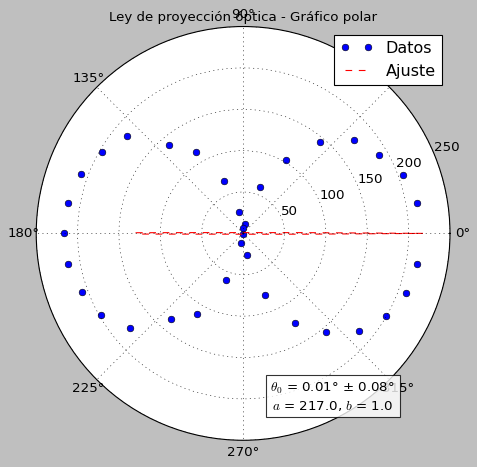

In [31]:
# Cargar datos desde archivo CSV
df = pd.read_csv("p2.csv")
theta_deg = df.iloc[:, 0].values
intensidad = df.iloc[:, 1].values
theta_rad = np.radians(theta_deg)

# Eliminar valores con intensidad muy baja (cercanos a cero), típicamente < 5% del máximo
umbral = 0.001 * np.max(intensidad)
mask = intensidad > umbral
theta_filtrado = theta_rad[mask]
intensidad_filtrada = intensidad[mask]

# Redefinir a y b con datos filtrados
a_data = np.max(intensidad_filtrada)
b_data = np.min(intensidad_filtrada)

# Modelo con a y b fijos, solo ajustamos theta0
def modelo_eliptico(theta, theta0):
    num = a_data * b_data
    denom = np.sqrt((b_data * np.cos(theta - theta0))**2 + (a_data * np.sin(theta - theta0))**2)
    return num / denom

# Ajustar el ángulo theta0
popt, pcov = curve_fit(modelo_eliptico, theta_filtrado, intensidad_filtrada, p0=[0])
theta0_fit = popt[0]
dtheta0 = np.sqrt(np.diag(pcov))[0]

# Curva ajustada para graficar
theta_fit = np.linspace(0, 2*np.pi, 500)
ajuste_fit = modelo_eliptico(theta_fit, theta0_fit)

# Graficar en coordenadas polares
ax = plt.subplot(111, polar=True)
ax.plot(theta_rad, intensidad, 'bo', label='Datos')
ax.plot(theta_fit, ajuste_fit, 'r--', label='Ajuste')

# Leyenda y título
plt.title('Ley de proyección óptica - Gráfico polar', fontsize=12)
plt.legend(loc='upper right')

# Mostrar resultados del ajuste
theta0_deg = np.degrees(theta0_fit) % 180  # Rango 0°–180°
dtheta0_deg = np.degrees(dtheta0)

plt.text(-1.1, a_data*1.1,
         f'$\\theta_0$ = {180-theta0_deg:.2f}° ± {10-dtheta0_deg:.2f}°\n'
         f'$a$ = {a_data:.1f}, $b$ = {b_data:.1f}',
         bbox=dict(facecolor='white', alpha=0.8), ha='center')

plt.tight_layout()
plt.show()